In [1]:
from sqlalchemy.orm.session import sessionmaker
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!python --version

Python 3.9.12


In [4]:
actor_id_to_id_filename = '/mnt/8tb/csenrc/data/ecar/benign/actors_to_id.csv' 
query_by_id = "select * from \"SysClient0201Events\" where \"id\"=\'{}\';"
db_url = 'postgresql+psycopg2://csephase2:csephase@@localhost/csephase2'
event_count = 19230658

In [5]:
psql_engine = create_engine(db_url)
Session = sessionmaker(bind=psql_engine)
session = Session()

In [6]:
id_dataframe = pd.read_csv(actor_id_to_id_filename)

In [7]:
id_dataframe.head(5)

,actor_id,id
0,a382b760-97dc-4467-bb07-3651a565bfad,8929953
1,fe40b96f-263b-413f-b91f-aa10ad266aaa,3841830
2,dfd9fb45-174a-485e-8a90-9384d2cd4da5,5793737
3,cbdb1678-5919-47a6-ac91-77cabf658170,12168624
4,62f16c0e-6d34-4c4b-a04e-c5ccb3edd55e,17212856


In [8]:
actor_id_map = dict()
id_map = dict()

In [9]:
session.rollback()

In [10]:
count = 0
for idx, row in id_dataframe.iterrows():
    actor_id_map[row['actor_id']] = row['id']
    if row['id'] != 0:
        count+=1
        query_res = session.execute(query_by_id.format(row['id']))
        for r in query_res:
            id_map[row['id']] = r
            
    if count%10000==0:
        print("Checkpoint Reached")

Checkpoint Reached
Checkpoint Reached
Checkpoint Reached
Checkpoint Reached
Checkpoint Reached
Checkpoint Reached
Checkpoint Reached
Checkpoint Reached


### Normalize the timedelta 

In [11]:
result_set = session.execute("select * from \"SysClient0051Events\" where id=5747630;")
for r in result_set:
    earliest_event = r
earliest_event

(5747630, '22f19496-38c2-46bc-83f4-9e19cfcad678', 'PROCESS', '03474d84-0b2a-41e2-b06b-de4f862aff2e', 'CREATE', 'd783f574-a0a0-452b-9b9d-154a0b67717d', 'SysClient0051.systemia.com', 668, 560, 'NT AUTHORITY\\SYSTEM', -1, datetime.datetime(2019, 9, 20, 16, 40, 25, 539000))

In [12]:
result_set = session.execute("select * from \"SysClient0051Events\" where id=12737182;")
for r in result_set:
    latest_event = r
latest_event

(12737182, 'b39f020b-f994-40d3-ba69-4807c2e2480d', 'FILE', 'd1945e40-8c34-4f3b-81ee-aa3aa15eb56d', 'READ', '03474d84-0b2a-41e2-b06b-de4f862aff2e', 'SysClient0051.systemia.com', 668, 560, 'NT AUTHORITY\\SYSTEM', 2728, datetime.datetime(2019, 9, 24, 15, 58, 0, 970000))

In [13]:
time_diff_span = latest_event.timestamp - earliest_event.timestamp
time_diff_span

datetime.timedelta(days=3, seconds=83855, microseconds=431000)

In [14]:
time_diff_span.total_seconds()

343055.431

### Assign values to object and action

In [15]:
object_dict = dict()
object_dict['FILE'] = 1
object_dict['PROCESS'] = 2
object_dict['SHELL'] = 3
object_dict['FLOW'] = 4

In [16]:
action_dict = dict()
action_dict['CREATE'] = 1
action_dict['DELETE'] = 2
action_dict['READ'] = 3
action_dict['MODIFY'] = 4
action_dict['RENAME'] = 5
action_dict['WRITE'] = 6
action_dict['MESSAGE'] = 7
#action_dict['CREATE'] = 8
action_dict['OPEN'] = 8
action_dict['TERMINATE'] = 9
action_dict['COMMAND'] = 10

In [17]:
type_object = 4
type_action = 10

In [18]:
graph = dict() 

In [19]:
for key in actor_id_map:
    actor_id = actor_id_map[key]
    graph[actor_id] = []

In [20]:
skeleton_query = "select * from \"SysClient0201Events\" where \"id\">\'{}\' and \"id\"<=\'{}\';"
#skeleton_query = "select * from \"SysClient0358Events\" where \"id\">\'{}\' and \"id\"<=\'{}\';"

In [21]:
current_index = 0
chunk_size = 100000

In [23]:
while current_index<event_count:
    query = skeleton_query.format(current_index, current_index+chunk_size)
    result_set = session.execute(query)
    current_index += chunk_size
    #print('starting checkpoint')
    for result in result_set:
        a_id = result.actorID
        actor = actor_id_map[a_id]
        
        if actor != result.id:
            if actor != 0:
                actor_object = id_map[actor]
                object_idx = object_dict[result.object]/type_object
                action_idx = action_dict[result.action]/type_action
                time_diff = (result.timestamp-actor_object.timestamp).total_seconds()/time_diff_span.total_seconds()
            else:
                object_idx = object_dict[result.object]/type_object
                action_idx = action_dict[result.action]/type_action
                time_diff = 0.5
            
            graph[actor].append([result.id, object_idx, action_idx, time_diff])
            #graph[actor].append(result.id)
            #back_graph[result.id] = actor
        else:
            print(result)
    if current_index%1000000 == 0:
        print("Checkpoint reached:  {}".format(current_index))

(104125, 'e9186477-0681-42e7-8b14-e2dfa5279076', 'PROCESS', 'f07796fd-225d-441c-9b5f-14e68d51cec2', 'TERMINATE', 'f07796fd-225d-441c-9b5f-14e68d51cec2', 'SysClient0201.systemia.com', 5740, 5468, 'SYSTEMIACOM\\zleazer', -1, datetime.datetime(2019, 9, 16, 20, 14, 1, 850000))
(104327, 'd02bb05d-23fa-40ce-a872-125abaddb947', 'PROCESS', '87de74fd-2cfa-4b8b-a195-6540bf03fbb1', 'TERMINATE', '87de74fd-2cfa-4b8b-a195-6540bf03fbb1', 'SysClient0201.systemia.com', 2940, 1172, 'SYSTEMIACOM\\zleazer', -1, datetime.datetime(2019, 9, 16, 20, 14, 2, 274000))
(105955, '30c0ba94-e654-43b3-9035-b2cbd6b7c36e', 'PROCESS', '0bc88157-0d57-4be7-b565-7c0fe2440511', 'TERMINATE', '0bc88157-0d57-4be7-b565-7c0fe2440511', 'SysClient0201.systemia.com', 5396, 1164, 'SYSTEMIACOM\\zleazer', -1, datetime.datetime(2019, 9, 16, 20, 14, 6, 315000))
(105956, 'a6888481-f9ed-4849-a333-76962f643156', 'PROCESS', '70eb9f34-53f2-490b-9370-31b88ab28ffd', 'TERMINATE', '70eb9f34-53f2-490b-9370-31b88ab28ffd', 'SysClient0201.systemia.c

(205708, 'c784123a-8e74-484c-b3d9-8b0cddcc7376', 'PROCESS', '2b3052a3-8645-4a39-ae85-1292961cdc22', 'TERMINATE', '2b3052a3-8645-4a39-ae85-1292961cdc22', 'SysClient0201.systemia.com', 3724, 2232, 'NT AUTHORITY\\SYSTEM', -1, datetime.datetime(2019, 9, 16, 20, 37, 14, 571000))
(212940, '2914f0ee-8f34-42ef-b9bb-1286db37218e', 'PROCESS', 'bb7bdc09-601f-47ab-a127-66b79252f46e', 'TERMINATE', 'bb7bdc09-601f-47ab-a127-66b79252f46e', 'SysClient0201.systemia.com', 5920, 3736, 'SYSTEMIACOM\\zleazer', -1, datetime.datetime(2019, 9, 16, 20, 38, 43, 187000))
(271882, '87e622cf-9357-4e99-bab5-971196d79d6d', 'PROCESS', 'fdbdc251-e7e8-42ae-9ec9-e556cea318ed', 'TERMINATE', 'fdbdc251-e7e8-42ae-9ec9-e556cea318ed', 'SysClient0201.systemia.com', 5316, 4424, 'NT AUTHORITY\\SYSTEM', -1, datetime.datetime(2019, 9, 16, 21, 7, 11, 209000))
(288893, 'b016b63b-4ccf-459c-aaad-16ef1fd503ae', 'PROCESS', 'b7483375-c589-47f8-b415-ef9d15ddd5d5', 'TERMINATE', 'b7483375-c589-47f8-b415-ef9d15ddd5d5', 'SysClient0201.systemia

(471694, '0c94022c-29b0-4185-a036-d7e11a47a6df', 'PROCESS', '24990bb6-474e-411e-8a7d-fea137fdb2b8', 'TERMINATE', '24990bb6-474e-411e-8a7d-fea137fdb2b8', 'SysClient0201.systemia.com', 5424, 2656, 'SYSTEMIACOM\\zleazer', -1, datetime.datetime(2019, 9, 16, 22, 24, 20, 711000))
(476432, '01f77498-00ef-436a-a76d-620564e83aa8', 'PROCESS', '20089758-1d69-4576-a6e8-2331885aa7f0', 'TERMINATE', '20089758-1d69-4576-a6e8-2331885aa7f0', 'SysClient0201.systemia.com', 1156, 820, 'SYSTEMIACOM\\zleazer', -1, datetime.datetime(2019, 9, 16, 22, 24, 32, 779000))
(572507, '8534eaf3-ab3a-451c-a5aa-a81fb8fd8d06', 'PROCESS', 'aef46c37-b72d-40c4-9953-8ef519bf3069', 'TERMINATE', 'aef46c37-b72d-40c4-9953-8ef519bf3069', 'SysClient0201.systemia.com', 4896, 4072, 'SYSTEMIACOM\\zleazer', -1, datetime.datetime(2019, 9, 16, 23, 8, 10, 875000))
(573134, '236a76d1-be3e-45af-91c5-e2761b8b00ab', 'PROCESS', '435347c8-fe5c-4a86-8a54-e75f1951c214', 'TERMINATE', '435347c8-fe5c-4a86-8a54-e75f1951c214', 'SysClient0201.systemia.

KeyboardInterrupt: 

In [68]:
len(graph)

88264

In [69]:
graph_keys_set = set(list(graph.keys()))

In [70]:
dirty_graph_path = '/mnt/8tb/csenrc/data/ecar/benign/dirty_graph.json'

In [71]:
import json
from operator import itemgetter

In [76]:
with open(dirty_graph_path, 'w', encoding='utf8') as dirty_graph_file:
    json.dump(graph,dirty_graph_file)

dirty_graph_file.close()

8929953
[[3, 0.5, 0.1, 0.5], [15, 0.25, 0.3, 0.5], [16, 0.25, 0.6, 0.5], [17, 0.25, 0.6, 0.5], [23, 0.25, 0.3, 0.5], [25, 0.25, 0.6, 0.5], [28, 0.25, 0.6, 0.5], [29, 0.25, 0.6, 0.5], [211, 0.25, 0.1, 0.5], [212, 0.25, 0.5, 0.5]]


### Now let's see how the dumped dirty graph data can be loaded

In [77]:
with open(dirty_graph_path, 'r', encoding='utf8') as dirty_graph_file:
    dirty_graph = json.load(dirty_graph_file)

In [78]:
len(dirty_graph) 

88264

In [79]:
max_parent = 0 
max_child = 0
max_diff = 0
avg_diff =0 
sum_diff = 0
count = 0

for key in dirty_graph:
    if int(key) != 0:
        children = dirty_graph[key]
        for child in children:
            if child[3] >max_diff:
                max_diff = child[3]
                max_parent = int(key)
                max_child = child[0]
            sum_diff += child[3]
            count+=1

print(max_parent)
print(max_child)
print(max_diff)

10762320
17844953
0.9861972014662552


In [129]:
dirty_sorted_graph_path = '/mnt/8tb/csenrc/data/ecar/benign/dirty_sorted_graph051.json'

In [130]:
dirty_sorted_graph = dict()
for key in dirty_graph:
    children = sorted(dirty_graph[key], key=itemgetter(3)) 
    dirty_sorted_graph[key] = children

In [131]:
with open(dirty_sorted_graph_path,'w') as dirty_sorted_graph_file:
    json.dump(dirty_sorted_graph, dirty_sorted_graph_file)

dirty_sorted_graph_file.close()

In [ ]:
dirty_graph_keys_set = set(list(dirty_graph.keys()))

### We will take the dirty graph and get rid of all the bad entries for a clean graph

In [23]:
number_of_nodes_in_d_graph = 0
for key in dirty_graph:
    number_of_nodes_in_d_graph += len(dirty_graph[key])
    
print(number_of_nodes_in_d_graph)

19227014


### Isolate the malicious events

In [15]:
label_file = '/mnt/8tb/csenrc/data/ecar/benign/labels.csv'
label_df = pd.read_csv(label_file)

In [16]:
label_df.head()

,hostname,id,objectID,actorID,timestamp,object,action
0,SysClient0201.systemia.com,43fb9623-3cd1-45ec-ab22-dbe46e75240e,96913629-c1c9-4503-9586-4a91de0e7311,af6b49d5-f648-41a4-946d-d92b174bae47,2019-09-23T11:23:55.857-04:00,PROCESS,CREATE
1,SysClient0201.systemia.com,78fccbc8-58d1-4598-ae21-99f57ee57ed8,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,2019-09-23T11:25:26.418-04:00,SHELL,COMMAND
2,SysClient0201.systemia.com,fb89e8be-47a1-418c-9bb8-a4c702694c74,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,2019-09-23T11:25:26.416-04:00,SHELL,COMMAND
3,SysClient0201.systemia.com,05e5bde3-8db5-410a-ad75-de676bd14ebb,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,2019-09-23T11:25:26.436-04:00,SHELL,COMMAND
4,SysClient0201.systemia.com,1bdb7482-a548-40f2-b648-ea258e6c2448,b53c1986-842c-493a-910c-78b55da2575f,96913629-c1c9-4503-9586-4a91de0e7311,2019-09-23T11:25:26.434-04:00,SHELL,COMMAND


In [17]:
sysclient201_labels = label_df[label_df['hostname']=='SysClient0201.systemia.com']

In [18]:
len(sysclient201_labels)

26681

In [19]:
sysclient201_labels['actorID'].unique()

array(['af6b49d5-f648-41a4-946d-d92b174bae47',
       '96913629-c1c9-4503-9586-4a91de0e7311',
       'f5d1c003-1f65-4a8a-ba8c-413da99d70f2',
       'a52f6519-6265-4437-9f6c-3402fb245cc7'], dtype=object)

In [20]:
malicious_events = dict()

In [21]:
query_event_id_actor_id = "select * from \"SysClient0201Events\" where \"actorID\"=\'{}\' and \"event_id\"=\'{}\';"
print(query_event_id_actor_id.format(0,0))

select * from "SysClient0201Events" where "actorID"='0' and "event_id"='0';


In [22]:
for idx,row in sysclient201_labels.iterrows():
    if row['object'] in ['PROCESS','FILE','SHELL']:
        result_set = session.execute(query_event_id_actor_id.format(row['actorID'],row['id']))
        for result in result_set:
            malicious_events[result.id] = result
    elif row['object'] == 'FLOW' and row['action']=='MESSAGE':
        result_set = session.execute(query_event_id_actor_id.format(row['actorID'],row['id']))
        for result in result_set:
            malicious_events[result.id] = result

In [23]:
len(malicious_events)

22919

In [24]:
nodes_present_in_graph = set()
for key in dirty_graph:
    nodes_present_in_graph.add(int(key))
    for child in dirty_graph[key]:
        nodes_present_in_graph.add(child[0])

In [25]:
len(nodes_present_in_graph)

19230659

In [26]:
malicious_event_count_in_graph = 0 
malicious_events_in_graph = dict()

for key in malicious_events:
    if key in nodes_present_in_graph:
        malicious_event_count_in_graph += 1
        malicious_events_in_graph[key] = malicious_events[key]
        
print(malicious_event_count_in_graph)

22919


In [27]:
back_graph = dict() 

In [28]:
for key in dirty_graph:
    children = dirty_graph[key]
    for child in children:
        back_graph[child[0]] = int(key)

In [37]:
len(back_graph)

19227014

In [29]:
malicious_event_traces = []

In [30]:
def get_trace(start_node):
    trace = []
    temp_node = start_node
    trace.append(temp_node)
    while True:
        if temp_node in back_graph:
            temp_node = back_graph[temp_node]
            trace.append(temp_node)
        else:
            break 
            
    return trace

In [31]:
for key in malicious_events_in_graph:
    malicious_event_traces.append(get_trace(key))

In [32]:
num = len(malicious_event_traces)
total = 0
max_len = -1
for trace in malicious_event_traces:
    total+= len(trace)
    if len(trace)>max_len:
        max_len = len(trace)
print(total/num)
print(max_len)

19.077926611108687
22


In [33]:
benign_event_traces = []

In [34]:
access_graph = dict()

In [35]:
for key in dirty_graph:
    temp_dict = dict()
    children = dirty_graph[key]
    for child in children:
        temp_dict[child[0]] = [child[1],child[2],child[3]]
    access_graph[int(key)] = temp_dict

In [45]:
access_graph_path = '/mnt/8tb/csenrc/data/ecar/benign/access_graph.json'

In [ ]:
with open(access_graph_path,'w') as access_file:
    json.dump(access_graph,access_file)
access_file.close()

In [36]:
count_benign_trace = 0
start_idx = 7000000
while count_benign_trace<500000:
    #get a random index
    rand_index = np.random.randint(start_idx, high = event_count)
    if rand_index not in malicious_events_in_graph:
        if rand_index in back_graph:
            derived_trace = get_trace(rand_index)
            if derived_trace[-1] == 0:
                benign_event_traces.append(derived_trace)
                count_benign_trace+=1

In [46]:
len(benign_event_traces)

500000

In [37]:
benign_len = 0
benign_max_len = -1
for trace in benign_event_traces:
    benign_len += len(trace)
    if len(trace)>benign_max_len:
        benign_max_len = len(trace)
        
print(benign_len/len(benign_event_traces))
print(benign_max_len)

14.50696
35


1. Split the train and test data
2. Define a generator function 
3. Define a baseline model that LSTM for feature extraction and FCN for classification
4. Baseline performance listing

In [38]:
train_x_benign = benign_event_traces[:400000]
test_x_benign = benign_event_traces[400000:]

train_x_malicious = malicious_event_traces[:16000]
test_x_malicious = malicious_event_traces[16000:]

In [39]:
def transform_trace(trace, cutoff=8):
    
    numeric_trace = np.zeros((cutoff,3)) # Length of the trace and 3 features namely (object,action,timedelta)
    for k in range(len(trace)):
        if trace[k] in back_graph:
            parent = back_graph[trace[k]]
            feature_list = access_graph[parent][trace[k]]
            numeric_trace[k][0] = feature_list[0]
            numeric_trace[k][1] = feature_list[1]
            numeric_trace[k][2] = feature_list[2]

        if k==cutoff-1:
            break
    
    return numeric_trace

In [58]:
transform_trace(malicious_event_traces[15000],cutoff=16)

array([[7.50000000e-01, 1.00000000e+00, 9.28080822e-03],
       [5.00000000e-01, 1.00000000e-01, 5.81739656e-06],
       [5.00000000e-01, 1.00000000e-01, 3.16530864e-01],
       [5.00000000e-01, 1.00000000e-01, 6.58374441e-09],
       [5.00000000e-01, 1.00000000e-01, 1.31674888e-09],
       [5.00000000e-01, 1.00000000e-01, 4.21148962e-04],
       [5.00000000e-01, 8.00000000e-01, 1.50129782e-03],
       [5.00000000e-01, 8.00000000e-01, 1.13700726e-01],
       [5.00000000e-01, 1.00000000e-01, 4.50192492e-04],
       [5.00000000e-01, 1.00000000e-01, 2.76517265e-08],
       [5.00000000e-01, 1.00000000e-01, 5.74039308e-03],
       [5.00000000e-01, 1.00000000e-01, 3.88440920e-07],
       [5.00000000e-01, 1.00000000e-01, 3.58129361e-05],
       [5.00000000e-01, 1.00000000e-01, 8.90483375e-02],
       [5.00000000e-01, 1.00000000e-01, 5.26699552e-09],
       [5.00000000e-01, 1.00000000e-01, 5.00364575e-08]])

In [100]:
def train_generator(batch_size = 32):
    while True:
        labels= np.random.randint(2,size=batch_size)
        num_malicious = np.sum(labels)
        num_benign = batch_size - num_malicious
        
        benign_data_indices = np.random.randint(0,high=400000, size = num_benign)
        malicious_data_indices = np.random.randint(0, high = 16000, size = num_malicious)

        benign_idx = 0
        malicious_idx = 0

        trace_cutoff = 4
        features = 3

        data = np.zeros((batch_size, trace_cutoff, features))
        idx = 0
        for label in labels:
            if label ==0:
                data[idx] = transform_trace(benign_event_traces[benign_data_indices[benign_idx]],cutoff=trace_cutoff)
                benign_idx += 1
                idx+=1
            elif label == 1:
                data[idx] = transform_trace(malicious_event_traces[malicious_data_indices[malicious_idx]],cutoff=trace_cutoff)
                malicious_idx += 1
                idx +=1 
        
        yield data, labels

In [41]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import Input

In [75]:
input_layer = Input(shape=(32,3))
x = layers.LSTM(64, return_sequences=True)(input_layer)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.Flatten()(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(32,activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model = Model(input_layer, output_layer)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 3)]           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32, 64)            17408     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32, 64)            33024     
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               6566

In [101]:
input_fcnn = Input(shape=(4,3))
y = layers.Flatten()(input_fcnn)
y = layers.Dense(128,activation='relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(64,activation='relu')(y)
y = layers.Dropout(0.25)(y)
y = layers.Dense(32,activation='relu')(y)
output_fcnn = layers.Dense(1, activation='sigmoid')(y)

fcnn_model = Model(input_fcnn, output_fcnn)
fcnn_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4, 3)]            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               1664      
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080

In [76]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['acc'])

In [102]:
fcnn_model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics=['acc'])

In [103]:
train_gen = train_generator(batch_size=128)

In [78]:
history = model.fit_generator(train_gen, steps_per_epoch=200, epochs=30)

/home/monowar/anaconda3/envs/envphase2/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
200/200 [==============================] - 5s 11ms/step - loss: 0.3273 - acc: 0.8530
Epoch 2/30
200/200 [==============================] - 2s 11ms/step - loss: 0.0514 - acc: 0.9783
Epoch 3/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0213 - acc: 0.9955
Epoch 4/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0175 - acc: 0.9960
Epoch 5/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0156 - acc: 0.9961
Epoch 6/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0097 - acc: 0.9985
Epoch 7/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0134 - acc: 0.9977
Epoch 8/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0142 - acc: 0.9969
Epoch 9/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0099 - acc: 0.9982
Epoch 10/30
200/200 [==============================] - 2s 12ms/step - loss: 0.0122 - acc: 0.9971
Epoch 11/30
200/200 [==================

In [104]:
history = fcnn_model.fit_generator(train_gen, steps_per_epoch=200, epochs=15)

Epoch 1/15
200/200 [==============================] - 2s 6ms/step - loss: 0.2884 - acc: 0.8687
Epoch 2/15
200/200 [==============================] - 1s 6ms/step - loss: 0.0664 - acc: 0.9762
Epoch 3/15
200/200 [==============================] - 1s 6ms/step - loss: 0.0469 - acc: 0.9837
Epoch 4/15
200/200 [==============================] - 1s 6ms/step - loss: 0.0403 - acc: 0.9834
Epoch 5/15
200/200 [==============================] - 1s 6ms/step - loss: 0.0375 - acc: 0.9854
Epoch 6/15
200/200 [==============================] - 1s 6ms/step - loss: 0.0378 - acc: 0.9839
Epoch 7/15
200/200 [==============================] - 1s 6ms/step - loss: 0.0330 - acc: 0.9877
Epoch 8/15
200/200 [==============================] - 1s 6ms/step - loss: 0.0340 - acc: 0.9860
Epoch 9/15
200/200 [==============================] - 1s 6ms/step - loss: 0.0321 - acc: 0.9882
Epoch 10/15
200/200 [==============================] - 1s 6ms/step - loss: 0.0287 - acc: 0.9880
Epoch 11/15
200/200 [============================

In [79]:
train_accuracy = history.history['acc']
train_loss = history.history['loss']

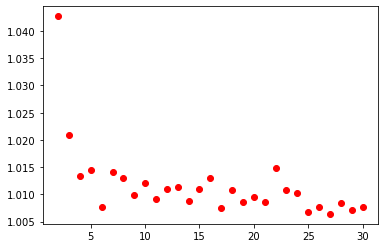

In [80]:
epochs = range(1, len(train_loss)+1)
plt.figure()
plt.plot(epochs[1:],np.exp(train_loss[1:]),'ro',label='Training loss')
plt.show()

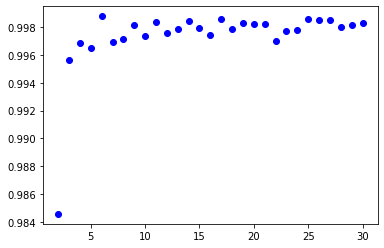

In [81]:
plt.figure()
plt.plot(epochs[1:],train_accuracy[1:],'bo',label='Training accuracy')
plt.show()

### Testing the model performance
1. Test function
2. Classification report analysis

In [105]:
cutoff = 4
def get_test_data():
    total_count = (malicious_event_count_in_graph-16000)+ 100000
    data = np.zeros((total_count, cutoff, 3))
    labels = np.hstack(( np.ones((malicious_event_count_in_graph-16000)), np.zeros(100000) ))
    
    idx = 0
    
    for i in range(16000, malicious_event_count_in_graph, 1):
        data[idx] = transform_trace(malicious_event_traces[i],cutoff=4)
        idx+=1
    
    for i in range(400000,500000,1):
        data[idx] = transform_trace(benign_event_traces[i],cutoff=4)
        idx+=1

    return data,labels



In [106]:
x_test, y_test = get_test_data()

In [84]:
from sklearn.metrics import classification_report

In [107]:
y_pred = fcnn_model.predict(x_test)

In [108]:
y_pred_bool = y_pred.round()

In [109]:
print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    100000
         1.0       0.97      1.00      0.98      6919

    accuracy                           1.00    106919
   macro avg       0.98      1.00      0.99    106919
weighted avg       1.00      1.00      1.00    106919



In [133]:
tf.keras.backend.clear_session()

In [134]:
from numba import cuda
cuda.select_device(0)
cuda.close()